In [1]:
import random
import matplotlib
import numpy as np
import matplotlib.pyplot as plt


import tensorflow as tf
from tensorflow import data
from tensorflow.keras import Sequential, datasets, layers, models, losses, metrics, Model

In [2]:
tf.test.is_built_with_cuda()

True

### Load fashion MNIST dataset

In [3]:
(train_images,train_labels),(test_images,test_labels)=datasets.fashion_mnist.load_data()
class_names = ['T-shirt/top', 'Trouser', 'Pullover', 'Dress', 'Coat',
               'Sandal', 'Shirt', 'Sneaker', 'Bag', 'Ankle boot']

### Investigate the dataset

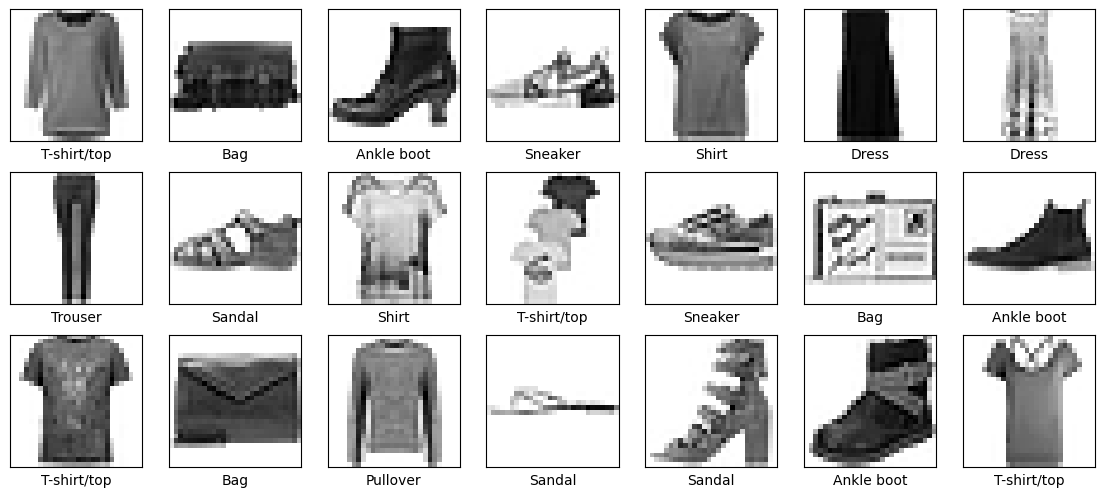

In [4]:
random.seed(1)
train_ids = list(range(len(train_labels)))
sample_ids = random.sample(train_ids,21)

plt.figure(figsize=[14,6])
for iindex in range(len(sample_ids)):
    plt.subplot(3,7,iindex+1)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(train_images[sample_ids[iindex]],cmap=plt.cm.binary)
    plt.xlabel(class_names[train_labels[sample_ids[iindex]]])
    
plt.show()

In [5]:
print("Training Data Distribution")
unique_elem,number_of_elem=np.unique(train_labels,return_counts=True)
print(np.c_[unique_elem.T,number_of_elem.T])

print("Test Data Distribution")
unique_elem,number_of_elem=np.unique(test_labels,return_counts=True)
print(np.c_[unique_elem.T,number_of_elem.T])

train_dataset_size = len(train_labels)
validation_dataset_size = 5000
test_dataset_size = 5000

Training Data Distribution
[[   0 6000]
 [   1 6000]
 [   2 6000]
 [   3 6000]
 [   4 6000]
 [   5 6000]
 [   6 6000]
 [   7 6000]
 [   8 6000]
 [   9 6000]]
Test Data Distribution
[[   0 1000]
 [   1 1000]
 [   2 1000]
 [   3 1000]
 [   4 1000]
 [   5 1000]
 [   6 1000]
 [   7 1000]
 [   8 1000]
 [   9 1000]]


In [6]:
print(train_images.shape)
print(np.max(train_images))
print(np.min(train_images))

(60000, 28, 28)
255
0


### Preprocess the dataset
-   Normalize 
-   Form datasets
    -   Train
    -   Validation
    -   Test
-   Shuffle and create Batches for training

In [7]:
normalization_factor = np.max(train_images)
train_images = train_images/normalization_factor
test_images = test_images/normalization_factor

In [8]:
train_dataset = data.Dataset.from_tensor_slices((train_images,train_labels))
validation_dataset = data.Dataset.from_tensor_slices((test_images[:validation_dataset_size],test_labels[:validation_dataset_size]))
test_dataset = data.Dataset.from_tensor_slices((test_images[test_dataset_size:],test_labels[test_dataset_size:]))

In [9]:
train_dataset = train_dataset.shuffle(train_dataset_size).batch(128)
validation_dataset = validation_dataset.batch(128)
test_dataset = test_dataset.batch(128)

### Build the model

In [11]:
# Define the input shape
input_shape = (28, 28, 1)

# Create two separate input layers for each filter size
input = layers.Input(shape=input_shape)

# Define the first convolutional layer with a kernel size of (3, 3)
conv1_3x3 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(input)

# Define the second convolutional layer with a kernel size of (8, 4)
conv2_8x4 = layers.Conv2D(16, kernel_size=(8, 4), activation='relu', kernel_initializer='glorot_uniform', padding='same')(input)

# Define the second convolutional layer with a kernel size of (4, 8)
conv3_4x8 = layers.Conv2D(16, kernel_size=(4, 8), activation='relu', kernel_initializer='glorot_uniform', padding='same')(input)

# Concatenate the two convolutional layers along the last axis (channel axis)
concatenated = layers.Concatenate(axis=-1)([conv1_3x3, conv2_8x4, conv3_4x8])

# Batch normalize
normalize = layers.BatchNormalization(axis=-1)(concatenated)

# Apply max-pooling
pooled = layers.MaxPooling2D(pool_size=(2, 2))(normalize)

# Define a convolutional layer with a kernel size of (3, 3) 
conv3_3x3 = layers.Conv2D(32, kernel_size=(3, 3), activation='relu', kernel_initializer='glorot_uniform', padding='same')(pooled)

# Flatten the output
flattened = layers.Flatten()(conv3_3x3)

# Fully connected layer
dense1 = layers.Dense(128, activation='relu')(flattened)

# Dropout layer
dropout1 = layers.Dropout(0.5)(dense1)

# Fully connected layer
dense2 = layers.Dense(64, activation='relu')(dropout1)

# Output layer
output = layers.Dense(10)(dense2)

# Create a model that takes two inputs and produces an output
model = Model(inputs=input, outputs=output)

# Print the model summary
model.summary()

Model: "model_1"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_2 (InputLayer)           [(None, 28, 28, 1)]  0           []                               
                                                                                                  
 conv2d_4 (Conv2D)              (None, 28, 28, 32)   320         ['input_2[0][0]']                
                                                                                                  
 conv2d_5 (Conv2D)              (None, 28, 28, 16)   528         ['input_2[0][0]']                
                                                                                                  
 conv2d_6 (Conv2D)              (None, 28, 28, 16)   528         ['input_2[0][0]']                
                                                                                            

### Compile the model

In [12]:
model.compile(
    optimizer = 'Adam',
    loss = losses.SparseCategoricalCrossentropy(from_logits=True),
    metrics = ['accuracy'])

In [13]:
CHECKPOINT_PREFIX = 'CNN_Fashion_MNIST/CFM_{epoch}'
checkpoint = tf.keras.callbacks.ModelCheckpoint(
    filepath=CHECKPOINT_PREFIX,
    monitor='val_accuracy',
    mode='max')

callbacks = [
    checkpoint
]

### Fit the model

In [14]:
hist = model.fit(train_dataset,
          epochs=25,
          validation_data=validation_dataset,
          callbacks = callbacks)

Epoch 1/25
469/469 [==============================] - ETA: 0s - loss: 0.5417 - accuracy: 0.8083

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_1\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_1\assets


469/469 [==============================] - 9s 11ms/step - loss: 0.5417 - accuracy: 0.8083 - val_loss: 0.5250 - val_accuracy: 0.8788
Epoch 2/25
466/469 [============================>.] - ETA: 0s - loss: 0.3354 - accuracy: 0.8807

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_2\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_2\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.3354 - accuracy: 0.8809 - val_loss: 0.2960 - val_accuracy: 0.8962
Epoch 3/25
468/469 [============================>.] - ETA: 0s - loss: 0.2869 - accuracy: 0.8975

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_3\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_3\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2868 - accuracy: 0.8976 - val_loss: 0.3028 - val_accuracy: 0.8950
Epoch 4/25
468/469 [============================>.] - ETA: 0s - loss: 0.2516 - accuracy: 0.9089

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_4\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_4\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2514 - accuracy: 0.9089 - val_loss: 0.2844 - val_accuracy: 0.9038
Epoch 5/25
468/469 [============================>.] - ETA: 0s - loss: 0.2330 - accuracy: 0.9141

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_5\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_5\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2330 - accuracy: 0.9141 - val_loss: 0.2467 - val_accuracy: 0.9064
Epoch 6/25
462/469 [============================>.] - ETA: 0s - loss: 0.2118 - accuracy: 0.9229

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_6\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_6\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.2118 - accuracy: 0.9227 - val_loss: 0.2490 - val_accuracy: 0.9104
Epoch 7/25
463/469 [============================>.] - ETA: 0s - loss: 0.1970 - accuracy: 0.9273

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_7\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_7\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1972 - accuracy: 0.9272 - val_loss: 0.2589 - val_accuracy: 0.9124
Epoch 8/25
462/469 [============================>.] - ETA: 0s - loss: 0.1844 - accuracy: 0.9336

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_8\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_8\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1844 - accuracy: 0.9334 - val_loss: 0.2451 - val_accuracy: 0.9184
Epoch 9/25
465/469 [============================>.] - ETA: 0s - loss: 0.1696 - accuracy: 0.9368

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_9\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_9\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1697 - accuracy: 0.9367 - val_loss: 0.2765 - val_accuracy: 0.9072
Epoch 10/25
468/469 [============================>.] - ETA: 0s - loss: 0.1619 - accuracy: 0.9400

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_10\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_10\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1618 - accuracy: 0.9400 - val_loss: 0.2475 - val_accuracy: 0.9194
Epoch 11/25
469/469 [==============================] - ETA: 0s - loss: 0.1542 - accuracy: 0.9427

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_11\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_11\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1542 - accuracy: 0.9427 - val_loss: 0.2717 - val_accuracy: 0.9176
Epoch 12/25
463/469 [============================>.] - ETA: 0s - loss: 0.1431 - accuracy: 0.9467

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_12\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_12\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1429 - accuracy: 0.9468 - val_loss: 0.3040 - val_accuracy: 0.9108
Epoch 13/25
468/469 [============================>.] - ETA: 0s - loss: 0.1344 - accuracy: 0.9501

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_13\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_13\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1343 - accuracy: 0.9501 - val_loss: 0.2627 - val_accuracy: 0.9172
Epoch 14/25
465/469 [============================>.] - ETA: 0s - loss: 0.1277 - accuracy: 0.9521

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_14\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_14\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1279 - accuracy: 0.9521 - val_loss: 0.2623 - val_accuracy: 0.9208
Epoch 15/25
464/469 [============================>.] - ETA: 0s - loss: 0.1193 - accuracy: 0.9559

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_15\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_15\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.1196 - accuracy: 0.9558 - val_loss: 0.2764 - val_accuracy: 0.9238
Epoch 16/25
465/469 [============================>.] - ETA: 0s - loss: 0.1140 - accuracy: 0.9576

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_16\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_16\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1139 - accuracy: 0.9575 - val_loss: 0.2847 - val_accuracy: 0.9158
Epoch 17/25
467/469 [============================>.] - ETA: 0s - loss: 0.1123 - accuracy: 0.9585

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_17\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_17\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1121 - accuracy: 0.9585 - val_loss: 0.2834 - val_accuracy: 0.9222
Epoch 18/25
465/469 [============================>.] - ETA: 0s - loss: 0.1028 - accuracy: 0.9611

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_18\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_18\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1029 - accuracy: 0.9610 - val_loss: 0.2924 - val_accuracy: 0.9232
Epoch 19/25
466/469 [============================>.] - ETA: 0s - loss: 0.1027 - accuracy: 0.9616

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_19\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_19\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.1026 - accuracy: 0.9616 - val_loss: 0.3162 - val_accuracy: 0.9166
Epoch 20/25
465/469 [============================>.] - ETA: 0s - loss: 0.0959 - accuracy: 0.9641

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_20\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_20\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.0958 - accuracy: 0.9641 - val_loss: 0.3591 - val_accuracy: 0.9044
Epoch 21/25
468/469 [============================>.] - ETA: 0s - loss: 0.0903 - accuracy: 0.9652

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_21\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_21\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.0903 - accuracy: 0.9652 - val_loss: 0.3323 - val_accuracy: 0.9222
Epoch 22/25
464/469 [============================>.] - ETA: 0s - loss: 0.0915 - accuracy: 0.9665

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_22\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_22\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.0913 - accuracy: 0.9665 - val_loss: 0.3278 - val_accuracy: 0.9144
Epoch 23/25
464/469 [============================>.] - ETA: 0s - loss: 0.0841 - accuracy: 0.9683

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_23\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_23\assets


469/469 [==============================] - 5s 11ms/step - loss: 0.0841 - accuracy: 0.9683 - val_loss: 0.2975 - val_accuracy: 0.9206
Epoch 24/25
466/469 [============================>.] - ETA: 0s - loss: 0.0831 - accuracy: 0.9692

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_24\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_24\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.0832 - accuracy: 0.9691 - val_loss: 0.3378 - val_accuracy: 0.9220
Epoch 25/25
464/469 [============================>.] - ETA: 0s - loss: 0.0804 - accuracy: 0.9704

INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_25\assets


INFO:tensorflow:Assets written to: CNN_Fashion_MNIST\CFM_25\assets


469/469 [==============================] - 5s 10ms/step - loss: 0.0803 - accuracy: 0.9703 - val_loss: 0.3561 - val_accuracy: 0.9124


### Evaluate on Test

In [15]:
loss, accuracy = model.evaluate(test_dataset)
print(f'The model cross entropy loss is {loss:0.4f}')
print(f'The model accuracy is {accuracy * 100:0.1f}%')

40/40 [==============================] - 0s 5ms/step - loss: 0.3261 - accuracy: 0.9222
The model cross entropy loss is 0.3261
The model accuracy is 92.2%


In [16]:
probability_model = Sequential([model, layers.Softmax()])
predictions = probability_model.predict(test_images)

313/313 [==============================] - 1s 2ms/step


In [17]:
predicted_labels = np.argmax(predictions,axis=1)
inaccurate_results = np.arange(predicted_labels.shape[0])[predicted_labels!=test_labels]

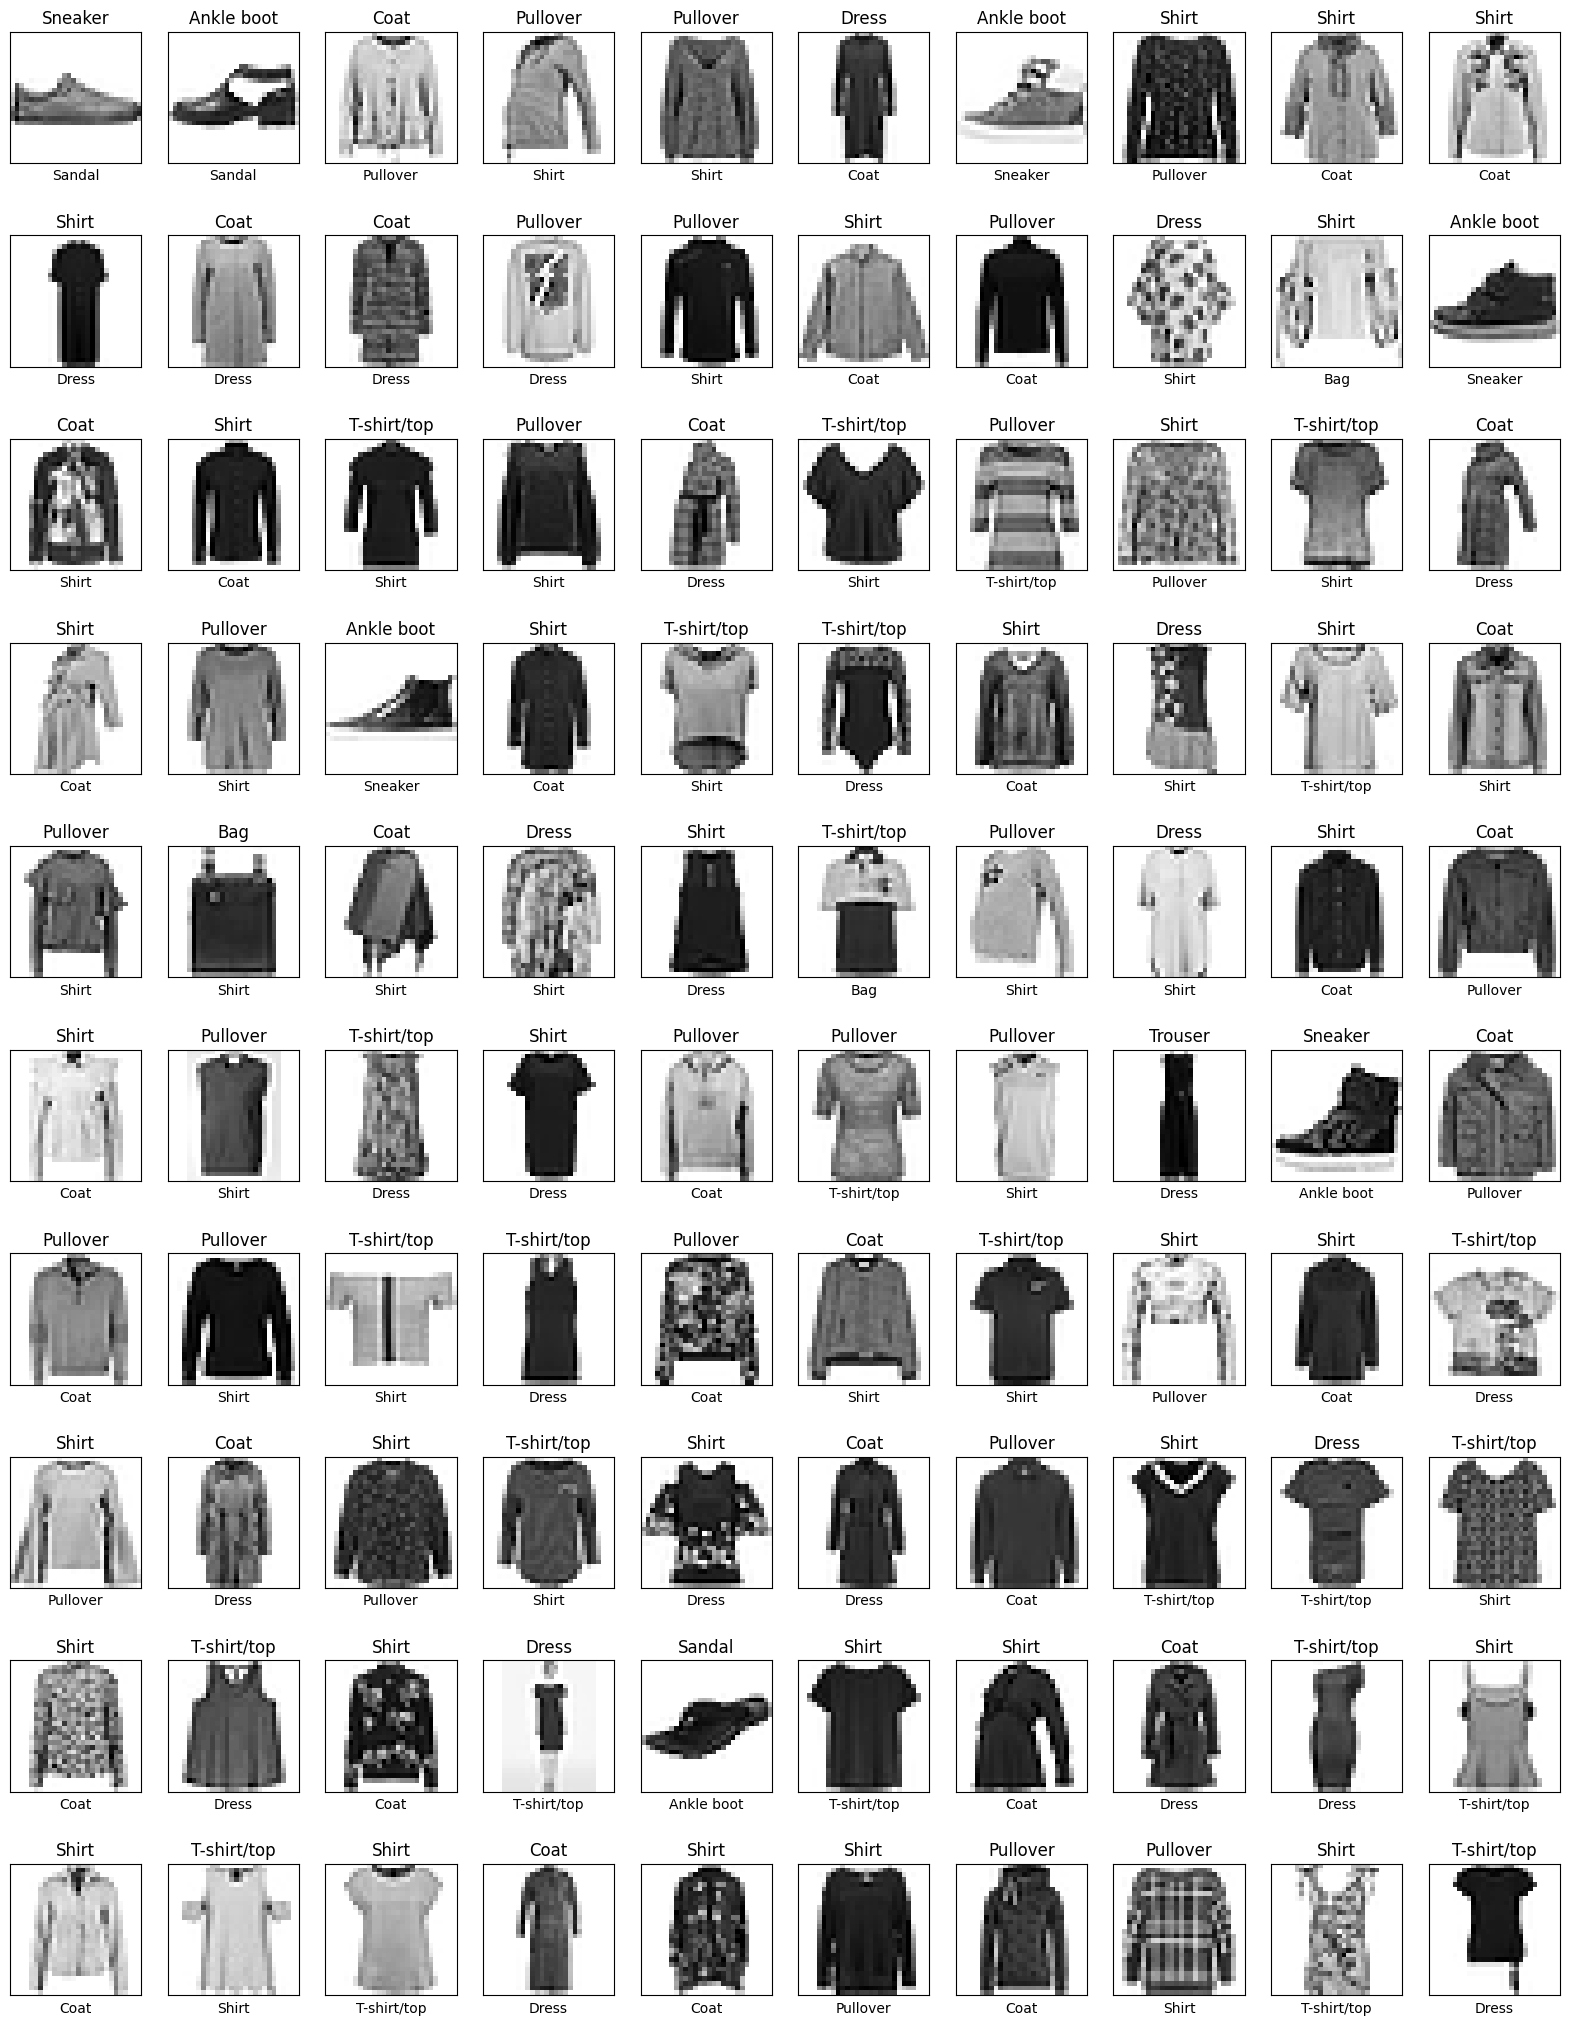

In [18]:
count=1
plt.figure(figsize=[20,26])
for iindex in inaccurate_results[:100]:
    plt.subplot(10,10,count)
    plt.xticks([])
    plt.yticks([])
    plt.grid(False)
    plt.imshow(test_images[iindex],cmap=plt.cm.binary)
    plt.title(class_names[test_labels[iindex]])
    plt.xlabel(class_names[predicted_labels[iindex]])
    count=count+1